### Imports

In [1]:
import pandas as pd
from pathlib import Path
import os
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import soundfile as sf
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torch.nn import init
import math, random

### DataFrame Setup

In [34]:
training_folder = 'training_set'
testing_folder = 'testing_set'

training_path = Path.cwd()/training_folder
testing_path = Path.cwd()/testing_folder
folder_paths = [training_path, testing_path]

classes = {'urination': 0, 'defecation': 1, 'silence': 2, 'speech': 3}
training_data_dict, testing_data_dict = {'relative_path': [], 'class_id': []}, {'relative_path': [], 'class_id': []}

for folder_path in folder_paths:
    for class_name in classes:
        path = f'{folder_path}/{class_name}'
        for file in os.listdir(path):
            if file.endswith('.wav'):
                if folder_path == training_path:
                    training_data_dict['relative_path'].append(os.path.join(f'{training_folder}\\{class_name}', file))
                    training_data_dict['class_id'].append(classes[class_name])
                else:
                    testing_data_dict['relative_path'].append(os.path.join(f'{testing_folder}\\{class_name}', file))
                    testing_data_dict['class_id'].append(classes[class_name])

training_df = pd.DataFrame(training_data_dict)
testing_df = pd.DataFrame(testing_data_dict)
training_df.head()

,relative_path,class_id
0,training_set\pee\number_one_quant_3_5.wav,0
1,training_set\pee\number_one_quant_3_6.wav,0
2,training_set\poop\number_two_quant_3_0.wav,1
3,training_set\poop\number_two_quant_3_2.wav,1
4,training_set\poop\number_two_quant_3_3.wav,1


### Audio Helper Functions

In [2]:

class AudioUtil():
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file) #signal and sample rate
    return (sig, sr)
  
  @staticmethod
  def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
  
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
  
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
  
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
  
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
  
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

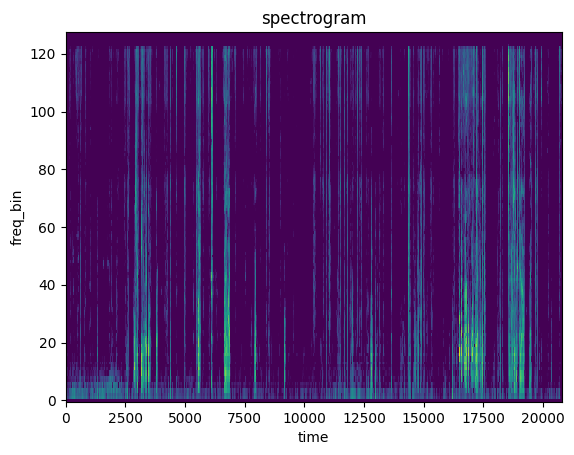

In [29]:
aud, sr = AudioUtil.open('audio\\number2\\live_sample.wav')
spec = AudioUtil.spectro_gram((aud,sr), n_mels=128, n_fft=1024, hop_len=512)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('time')
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(spec[0], title="spectrogram")

### Dataset Setup

In [36]:
class AudioDataSet(Dataset):
  def __init__(self, df):
    self.df = df
    self.duration = 4000
    self.channel = 2
    self.sr = 48000
    self.shift_pct = 0.4
            
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = self.df.loc[idx, 'relative_path']
    class_id = self.df.loc[idx, 'class_id']

    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

### Model

In [37]:
class Classifier(torch.torch.nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = torch.nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Convolution Block
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Convolution Block
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Convolution Block
        self.conv4 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = torch.nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = torch.nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = torch.nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

### Training and Testing Loops

In [38]:
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        inputs, labels = data[0], data[1]

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    if epoch % 50 == 0:
       print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print(f'Finished Training, total items {total_prediction}')

def testing(model, val_dl, validation):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
      for data in val_dl:
        inputs, labels = data[0], data[1]

        # Normalization
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Get predictions
        outputs = model(inputs)

        # Get class with highest score
        _, prediction = torch.max(outputs,1)
        if validation:
           correct_prediction += (prediction == labels).sum().item()
           total_prediction += prediction.shape[0]
           acc = correct_prediction/total_prediction
           print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
        else:
           print(prediction)

### Training Model and Inference

In [39]:
training_ds = AudioDataSet(training_df)
testing_ds = AudioDataSet(testing_df)

num_items = len(training_ds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train

train_ds, val_ds = random_split(training_ds, [num_train, num_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = torch.utils.data.DataLoader(testing_ds, batch_size=16, shuffle=False)

In [41]:
num_epochs=250
model = Classifier()

print("Training Set:")
training(model, train_dl, num_epochs)
print("\nValidation Set:")
testing(model, val_dl, True)
print("\nTesting Set:")
testing(model, test_dl, False)

Training Set:
Epoch: 0, Loss: 2.40, Accuracy: 0.07
Epoch: 50, Loss: 1.36, Accuracy: 0.71
Epoch: 100, Loss: 0.85, Accuracy: 0.71
Epoch: 150, Loss: 0.48, Accuracy: 0.86
Epoch: 200, Loss: 0.32, Accuracy: 0.93
Finished Training, total items 14

Validation Set:
Accuracy: 1.00, Total items: 4

Testing Set:
tensor([0, 2, 2, 3, 3, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2])
tensor([2, 3, 0, 3, 3, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1])
tensor([3, 2, 2, 2, 0, 1, 1, 3, 0, 2, 2, 2, 2, 2, 1, 0])
tensor([1, 1, 2, 2, 2, 3, 2, 1, 3, 2, 1, 2, 3, 0, 2, 3])
tensor([3, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 3, 3, 2, 2, 1])
tensor([0, 2, 3, 2, 3, 2, 0, 1, 2, 3, 3, 1, 1, 1, 2, 3])
tensor([1, 1, 0, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 0])
